**Import libs**

In [1]:
%matplotlib inline

import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pl

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

from root_numpy import root2array, rec2array, array2root

Welcome to JupyROOT 6.18/00


**Define function to get weights for arbitrary couplings**

In [2]:
#intro https://indico.cern.ch/event/904966/contributions/3832774/attachments/2023843/3384862/HH_combine_model_21Apr2018.pdf
def convert_coupling_diagramweight(coupling_nx3):
    # coupling_nx3 is (cv, c2v, kl)
    nrow=len(coupling_nx3[:,0])
    cv = coupling_nx3[:,0].reshape(nrow,1)
    c2v = coupling_nx3[:,1].reshape(nrow,1)
    kl = coupling_nx3[:,2].reshape(nrow,1)
    weights = np.matrix(np.zeros(nrow*6).reshape((nrow,6)),dtype=np.float64)
    weights[:,0] = np.power(np.multiply(cv,kl),2)
    weights[:,1] = np.power(cv,4)
    weights[:,2] = np.power(c2v,2)
    weights[:,3] = np.multiply(np.power(cv,3),kl)
    weights[:,4] = np.multiply(np.multiply(cv,c2v),kl)
    weights[:,5] = np.multiply(np.power(cv,2),c2v)
    return weights

CrossSec0 = np.array([0.0008095, 0.0013204, 0.000285, 0.0021291, 0.0005371, 0.001745])
#(cv, c2v, kl)
listOfCouplings0 = np.array([[1,1,1],[1,1,2],[1,0,1],[1,2,1],[0.5,1,1],[1.5,1,1]])

print("--------------------------- print CrossSec0:")
print(CrossSec0)

Coupling0 = convert_coupling_diagramweight(listOfCouplings0)
CouplingInv0=np.linalg.inv(Coupling0)
print("--------------------------- print Coupling0:")
print(Coupling0)
print("--------------------------- print CouplingInv0:")
print(CouplingInv0)

matrix_ele = np.matmul(CouplingInv0, CrossSec0)
print("---------------------------- print Matrix ele:")
print(matrix_ele)

--------------------------- print CrossSec0:
[0.0008095 0.0013204 0.000285  0.0021291 0.0005371 0.001745 ]
--------------------------- print Coupling0:
[[1.     1.     1.     1.     1.     1.    ]
 [4.     1.     1.     2.     2.     1.    ]
 [1.     1.     0.     1.     0.     0.    ]
 [1.     1.     4.     1.     2.     2.    ]
 [0.25   0.0625 1.     0.125  0.5    0.25  ]
 [2.25   5.0625 1.     3.375  1.5    2.25  ]]
--------------------------- print CouplingInv0:
[[-3.55555556e+00  8.88888889e-01 -5.55555556e-01  1.11111111e+00
  -2.22222222e+00  4.44444444e-01]
 [-3.11111111e+00  4.44444444e-01 -1.11111111e+00  2.22222222e-01
   8.88888889e-01  8.88888889e-01]
 [-1.00000000e+00 -1.20772136e-16  5.00000000e-01  5.00000000e-01
   1.23036614e-15 -4.52895511e-17]
 [ 6.66666667e+00 -1.33333333e+00  2.66666667e+00 -1.33333333e+00
   1.33333333e+00 -1.33333333e+00]
 [ 3.00000000e+00 -3.33333333e-01 -1.00000000e+00 -2.00000000e+00
   5.33333333e+00  2.03540888e-16]
 [-1.00000000e+00  3.333

In [128]:

listOfNewCouplings = np.array([[1,1,20],[1,1,0]])
NewCoupling = convert_coupling_diagramweight(listOfNewCouplings)
print("---------------------------- print composition of the samples:")
composition = np.matmul(NewCoupling, CouplingInv0)
np.set_printoptions(precision=3,suppress=True)
#composition = np.array([[-1234. ,  323.,  -190. ,  380. , -760.,   152.],[  -80.,    -0.  ,  36.,    45. ,    0. ,   -0.]])
print(composition)

newXsec = np.matmul(NewCoupling,matrix_ele.reshape(6,1))
print("---------------------------- print new Xsec:")
print(newXsec)


---------------------------- print composition of the samples:
[[-1234.      323.     -190.      380.     -760.      152.   ]
 [   -5.111     0.778    -1.111     2.222    -4.444     0.889]]
---------------------------- print new Xsec:
[[0.04]
 [0.  ]]


**Prepare dataset**

In [129]:
import ROOT as R

In [130]:

#f = R.TFile("c2v_kl_bdt/CV_0_5_C2V_1_0_C3_1_0_cut.root")
#tree = f.Get('Events')
#tree.Print()

In [131]:
#[1,1,1],[1,1,2],[1,0,1],[1,2,1],[0.5,1,1],[1.5,1,1]

filelist = {
    '1_1_1': 'c2v_kl_bdt/CV_1_0_C2V_1_0_C3_1_0_cut.root',
    '1_1_2': 'c2v_kl_bdt/CV_1_0_C2V_1_0_C3_2_0_cut.root',
    '1_0_1': 'c2v_kl_bdt/CV_1_0_C2V_0_0_C3_1_0_cut.root',
    '1_2_1': 'c2v_kl_bdt/CV_1_0_C2V_2_0_C3_1_0_cut.root',
    '0.5_1_1': 'c2v_kl_bdt/CV_0_5_C2V_1_0_C3_1_0_cut.root',
    '1.5_1_1': 'c2v_kl_bdt/CV_1_5_C2V_1_0_C3_1_0_cut.root',
}
order = {
    '1_1_1': 0,
    '1_1_2': 1,
    '1_0_1': 2,
    '1_2_1': 3,
    '0.5_1_1': 4,
    '1.5_1_1': 5,
}

branch_names = """VHH_H1_phi, VHH_H2_phi, selLeptons_phi_0""".split(",")
branch_names = [c.strip() for c in branch_names]
branch_names = (b.replace(" ", "_") for b in branch_names)
branch_names = list(b.replace("-", "_") for b in branch_names)

print(branch_names)

['VHH_H1_phi', 'VHH_H2_phi', 'selLeptons_phi_0']


In [132]:
kl_sample=[]

for i in filelist:
    print(i)
    signal = root2array(filelist[i],
                    "Events",
                    branch_names)
    signal = signal[0:int(len(signal)*0.01)] #only use 1% for demo
    signal = rec2array(signal)
    print("signal:",np.shape(signal))
    print(signal[0])
    print("weight: ",composition[0,order[i]], composition[1,order[i]])
    if len(kl_sample) == 0:
        kl_sample = signal
        kl_sample_weight=np.ones(signal.shape[0])*composition[0,order[i]]
        c2v_sample = signal
        c2v_sample_weight=np.ones(signal.shape[0])*composition[1,order[i]]
    else:    
        kl_sample = np.concatenate((kl_sample, signal))
        kl_sample_weight = np.concatenate((kl_sample_weight, np.ones(signal.shape[0])*composition[0,order[i]]))
        c2v_sample = np.concatenate((c2v_sample, signal))
        c2v_sample_weight = np.concatenate((c2v_sample_weight, np.ones(signal.shape[0])*composition[1,order[i]]))

    #print("kl_sample:", np.shape(kl_sample))
    #print(kl_sample[0])
    #print("kl_sample_weight:", np.shape(kl_sample_weight))
    #print(kl_sample_weight[0])
    #print("c2v_sample:",np.shape(c2v_sample))
    #print(c2v_sample[0])
    #print("c2v_sample_weight:",np.shape(c2v_sample_weight))
    #print(c2v_sample_weight[0])

1_1_1
signal: (2016, 3)
[ 2.58   2.066 -0.923]
weight:  -1233.9999999999993 -5.111111111111108
1_1_2
signal: (2232, 3)
[-1.293 -0.644 -2.727]
weight:  322.9999999999999 0.7777777777777772
1_0_1
signal: (2414, 3)
[ 0.574 -0.868 -2.959]
weight:  -189.99999999999994 -1.1111111111111112
1_2_1
signal: (2467, 3)
[-0.657  3.029  2.382]
weight:  379.9999999999995 2.2222222222222197
0.5_1_1
signal: (2740, 3)
[ 1.827 -1.797 -0.057]
weight:  -759.9999999999989 -4.444444444444439
1.5_1_1
signal: (1074, 3)
[ 0.833 -1.844 -1.949]
weight:  151.99999999999994 0.8888888888888887


In [134]:

X = np.concatenate((kl_sample, c2v_sample))
y = np.concatenate((np.ones(kl_sample.shape[0]), np.zeros(c2v_sample.shape[0])))
z = np.concatenate((kl_sample_weight, c2v_sample_weight))
print(np.shape(X))
print(X)
print(np.shape(y))
print(y)
print(np.shape(z))
print(z)

(25886, 3)
[[ 2.58   2.066 -0.923]
 [-0.792  2.229 -0.923]
 [-1.47   2.532  2.152]
 ...
 [-1.973 -0.533  1.994]
 [ 1.841 -2.524  1.994]
 [ 1.839 -2.118 -1.118]]
(25886,)
[1. 1. 1. ... 0. 0. 0.]
(25886,)
[-1234.    -1234.    -1234.    ...     0.889     0.889     0.889]


**Train BDT**

In [135]:
#X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.33, random_state=42)
X_train,X_test, y_train,y_test,z_train,z_test = train_test_split(X, y, z, test_size=0.33, random_state=492)

dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.05, random_state=True)
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=500,
                         learning_rate=0.5)

bdt.fit(X_train, y_train, z_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=4,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=0.05,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=True,
                            

**Performance checks**

In [136]:
print("On testing sample:")
y_predicted = bdt.predict(X_test)
print(classification_report(y_test, y_predicted, target_names=["background", "signal"]))
print("Area under ROC curve: %.4f"%(roc_auc_score(y_test, bdt.decision_function(X_test))))

print("On training sample:")
y_predicted = bdt.predict(X_train)
print(classification_report(y_train, y_predicted, target_names=["background", "signal"]))
print("Area under ROC curve: %.4f"%(roc_auc_score(y_train, bdt.decision_function(X_train))))


On testing sample:


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

  background       0.00      0.00      0.00      4296
      signal       0.50      1.00      0.66      4247

    accuracy                           0.50      8543
   macro avg       0.25      0.50      0.33      8543
weighted avg       0.25      0.50      0.33      8543

Area under ROC curve: 0.3852
On training sample:


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

  background       0.00      0.00      0.00      8647
      signal       0.50      1.00      0.67      8696

    accuracy                           0.50     17343
   macro avg       0.25      0.50      0.33     17343
weighted avg       0.25      0.50      0.33     17343

Area under ROC curve: 0.5586


**ROC curve**

ROC curve on testing sample:


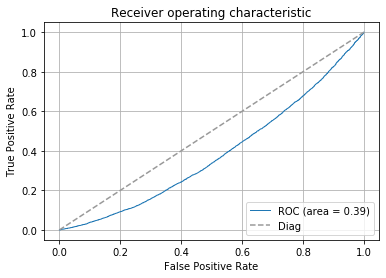

<Figure size 432x288 with 0 Axes>

In [137]:
print("ROC curve on testing sample:")
from sklearn.metrics import roc_curve, auc

decisions = bdt.decision_function(X_test)
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Diag')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()
plt.savefig('roc.png')

**BDT learning curve**

{'algorithm': 'SAMME', 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 4, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_impurity_split': None, 'base_estimator__min_samples_leaf': 0.05, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': False, 'base_estimator__random_state': True, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.05, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=True, splitter='best'), 'learning_rate': 0.5, 'n_estimators': 5

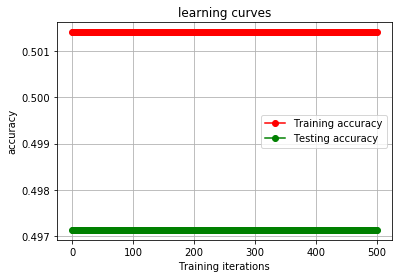

<Figure size 432x288 with 0 Axes>

In [139]:
print(bdt.get_params())

train_predictions = bdt.staged_predict(X_train)
test_predictions = bdt.staged_predict(X_test)

scores_test = []
scores_train = []
for i in test_predictions:
    scores_test.append(accuracy_score(i,y_test))
for i in train_predictions:
    scores_train.append(accuracy_score(i,y_train))

plt.figure()
plt.title("learning curves")
plt.xlabel("Training iterations")
plt.ylabel("accuracy")
plt.grid()
plt.plot(range(0,len(scores_train),1), scores_train, 'o-', color="r",label="Training accuracy")
plt.plot(range(0,len(scores_test),1), scores_test, 'o-', color="g",label="Testing accuracy")
plt.legend(loc="best")
plt.show()
plt.savefig('learning_curve.png')

**Overtraining Check**

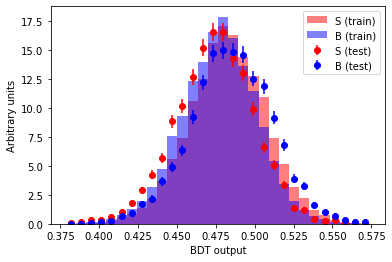

<Figure size 432x288 with 0 Axes>

In [140]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]

    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)

    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    plt.show()
    plt.savefig('bdt_dist.png')

compare_train_test(bdt, X_train, y_train, X_test, y_test)

**Correlation Plots**

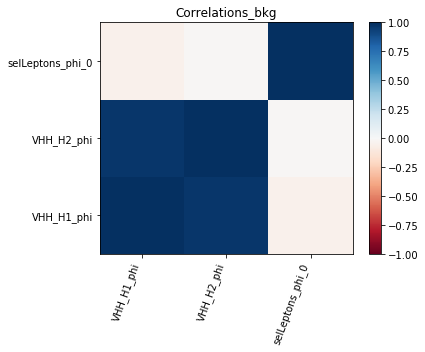

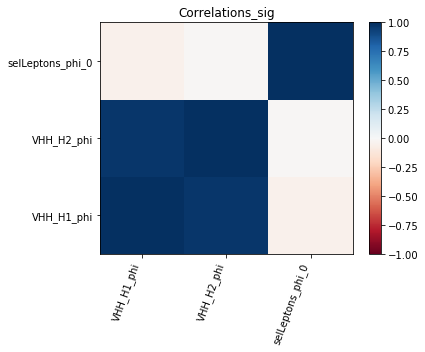

In [141]:
import pandas.core.common as com
from pandas.core.index import Index

from pandas.plotting import scatter_matrix


# Create a pandas DataFrame for our data
# this provides many convenience functions
# for exploring your dataset
# need to reshape y so it is a 2D array with one column
df = pd.DataFrame(np.hstack((X, y.reshape(y.shape[0], -1))),
                  columns=branch_names+['y'])


bg = df.y < 0.5
sig = df.y > 0.5

def correlations(data, extra_str, **kwds):
    """Calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    corrmat = data.corr(**kwds)

    fig, ax1 = plt.subplots(ncols=1, figsize=(6,5))
    
    opts = {'cmap': plt.get_cmap("RdBu"),
            'vmin': -1, 'vmax': +1}
    heatmap1 = ax1.pcolor(corrmat, **opts)
    plt.colorbar(heatmap1, ax=ax1)

    ax1.set_title("Correlations_"+extra_str)

    labels = corrmat.columns.values
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
        ax.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()
    
# remove the y column from the correlation matrix
# after using it to select background and signal
correlations(df[bg].drop('y', 1), 'bkg')
correlations(df[sig].drop('y', 1), 'sig')

**Pickle the output training data**

In [142]:
pl.dump(bdt, open("BDTAdaBoost.pk","wb"))

**Saving Classifier to Root Tree**

In [143]:
y_predicted = bdt.decision_function(X)
y_predicted.dtype = [('y', np.float64)]

array2root(y_predicted, "test-prediction.root", "BDToutput")

**Extra: load trained BDT and apply to input root data**

In [ ]:
branchlist=branch_names
treename="tree"
infilename='./datahist.root'
outfilename='./datahist_newMVA.root'
cutselection=''

inputpicklefile="BDTAdaBoost.pk"

X_in = root2array(infilename, treename, branches=branchlist, selection=cutselection)
bdt = pl.load(open(inputpicklefile,"rb"))
BDT_out = bdt.decision_function(pd.DataFrame(X_in))
BDT_out.dtype = [('BDToutput', np.float64)]
array2root(MVA_out, outfilename, "BDToutput")